Random Forest, kNN, VIF, heat map. 

In [1]:
import sklearn as sl
RSEED = 50

import numpy as np
import pandas as pd
import warnings

## Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

In [370]:
dataset = pd.read_csv('WILD_SHORT.csv')
dataset = dataset.sort_values(by="fpi_date")
dataset.head()

,lat_rnd,lon_rnd,fpi_date,fire_occurrence,max_fpi,min_fpi,avg_fpi,array_fpi,array_fod_lat,array_fod_lon,array_fpi_lat,array_fpi_lon,array_fod_id,rolled_up_rows
70674,41.5,-123.5,7/1/2009,0,54,28,43.666667,"{49,54,28}","{[NULL],[NULL],[NULL]}","{[NULL],[NULL],[NULL]}","{41.482369280673524,41.52506366231834,41.53783...","{-123.50441028179901,-123.52093260975258,-123....","{[NULL],[NULL],[NULL]}",3
83043,41.6,-121.9,7/1/2009,0,82,69,75.500000,"{69,82}","{[NULL],[NULL]}","{[NULL],[NULL]}","{41.58909630159099,41.64400190489369}","{-121.90513105280989,-121.8619481159476}","{[NULL],[NULL]}",2
86081,41.6,-120.5,7/1/2009,0,85,42,72.800000,"{42,85,79,81,77}","{[NULL],[NULL],[NULL],[NULL],[NULL]}","{[NULL],[NULL],[NULL],[NULL],[NULL]}","{41.55228514341317,41.638783865883596,41.58437...","{-120.4510081792993,-120.47988829132532,-120.5...","{[NULL],[NULL],[NULL],[NULL],[NULL]}",5
83477,41.6,-121.7,7/1/2009,0,58,48,52.250000,"{48,52,51,58}","{[NULL],[NULL],[NULL],[NULL]}","{[NULL],[NULL],[NULL],[NULL]}","{41.58168000346505,41.593478488934466,41.63651...","{-121.71393828053326,-121.65531320466623,-121....","{[NULL],[NULL],[NULL],[NULL]}",4
54399,41.3,-122.9,7/1/2009,0,65,26,38.000000,"{42,30,26,65,27}","{[NULL],[NULL],[NULL],[NULL],[NULL]}","{[NULL],[NULL],[NULL],[NULL],[NULL]}","{41.29639700173343,41.3392210195189,41.2535684...","{-122.86654599481663,-122.88253843884694,-122....","{[NULL],[NULL],[NULL],[NULL],[NULL]}",5


In [2]:
%load_ext sql
%sql ''
engine = create_engine('')

In [3]:
df=pd.read_sql('SELECT * FROM wildfire.combined WHERE extract(month from fpi_date)=7 and extract(year from fpi_date)!=2015',engine)
df_test=pd.read_sql('SELECT * FROM wildfire.combined WHERE extract(month from fpi_date)=7 and extract(year from fpi_date)=2015',engine)
df.head()

,lat_rnd,lon_rnd,fpi_date,elevation,fire_occurrence,max_fpi,min_fpi,avg_fpi,std_fpi,array_fpi,...,hundred_hour_dead_fuel_moist_percent,precip_amount_mm,max_relative_humidity_percent,min_relative_humidity_percent,specific_humidity_kg_kg,srad_wmm,temp_min_k,temp_max_k,mean_vapor_pressure_deficit_kpa,wind_speed_10m_m_s
0,39.7,-120.9,2013-07-01,1707.0,0,91,34,55.666667,30.859898,"[42, 34, 91]",...,6.649947,0.0,37.456738,15.490835,0.006956,320.660095,290.832214,308.543549,2.955878,2.712158
1,39.7,-120.9,2013-07-02,1707.0,0,40,33,37.333333,3.785939,"[33, 40, 39]",...,6.609696,0.0,51.485619,22.338930,0.008567,350.828552,289.635864,306.201141,2.308134,3.813781
2,39.7,-120.9,2013-07-03,1707.0,0,39,33,36.666667,3.214550,"[39, 38, 33]",...,6.531268,0.0,49.455910,22.811262,0.008244,352.115570,289.604675,305.181091,2.208249,4.002340
3,39.7,-120.9,2013-07-04,1707.0,0,40,32,36.333333,4.041452,"[32, 40, 37]",...,6.568206,0.0,48.911915,25.546572,0.007866,355.796600,289.020966,302.512177,1.886343,3.621990
4,39.7,-120.9,2013-07-05,1707.0,0,38,33,36.000000,2.645751,"[37, 38, 33]",...,6.797248,0.0,55.538628,27.341894,0.007576,357.130310,286.633820,300.769348,1.598734,3.730404


In [4]:
# Descriptive statistics for each column
df.describe()

,lat_rnd,lon_rnd,elevation,fire_occurrence,max_fpi,min_fpi,avg_fpi,std_fpi,rolled_up_rows,eng_release_comp_nfdrs,...,hundred_hour_dead_fuel_moist_percent,precip_amount_mm,max_relative_humidity_percent,min_relative_humidity_percent,specific_humidity_kg_kg,srad_wmm,temp_min_k,temp_max_k,mean_vapor_pressure_deficit_kpa,wind_speed_10m_m_s
count,314712.000000,314712.000000,311550.000000,314712.000000,314712.000000,314712.000000,314712.000000,289427.000000,314712.000000,314712.000000,...,314712.000000,314712.000000,314712.000000,314712.000000,314712.000000,314712.000000,314712.000000,314712.000000,314712.000000,314712.000000
mean,39.803251,-121.835225,909.043582,0.013040,61.700399,43.020841,52.242994,9.981559,3.301418,66.650045,...,8.374815,0.084939,65.401708,23.145190,0.007099,342.205616,286.174699,303.887008,2.014232,3.243794
std,1.387989,1.135383,666.239292,0.113448,18.451759,19.607659,18.175809,6.416875,1.108860,14.949313,...,2.876200,1.065636,19.724354,10.321427,0.001770,28.579374,4.070490,5.036619,0.788456,1.258708
min,37.000000,-124.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.100108,...,2.464072,0.000000,10.114160,1.585475,0.002134,101.679878,266.767975,279.190308,0.000000,0.473196
25%,38.700000,-122.800000,285.000000,0.000000,49.000000,27.000000,37.800000,4.949747,3.000000,56.807896,...,6.295111,0.000000,50.705161,16.110517,0.005878,338.026794,283.415619,300.577423,1.474397,2.431010
50%,39.900000,-121.800000,872.000000,0.000000,62.000000,37.000000,50.250000,9.073772,3.000000,69.156410,...,7.546464,0.000000,63.501989,21.048738,0.007135,349.407593,286.097748,304.194931,1.970908,2.996202
75%,41.000000,-120.875000,1468.000000,0.000000,77.000000,58.000000,66.500000,13.953494,4.000000,77.881821,...,9.902451,0.000000,80.555668,27.854930,0.008211,357.357330,288.974548,307.438934,2.490713,3.761563
max,42.000000,-120.000000,4000.000000,1.000000,99.000000,99.000000,99.000000,48.790368,60.000000,106.411102,...,22.170921,229.587433,100.000000,97.398079,0.016598,384.752289,300.698303,318.350250,5.218702,13.585548


In [5]:
df = df.dropna()
df_test = df_test.dropna()
df.columns

Index(['lat_rnd', 'lon_rnd', 'fpi_date', 'elevation', 'fire_occurrence',
       'max_fpi', 'min_fpi', 'avg_fpi', 'std_fpi', 'array_fpi',
       'array_fod_lat', 'array_fod_lon', 'array_fpi_lat', 'array_fpi_lon',
       'array_fod_id', 'rolled_up_rows', 'eng_release_comp_nfdrs',
       'burning_index_nfdrs', 'daily_ref_evapotrans_mm',
       'hundred_hour_dead_fuel_moist_percent', 'precip_amount_mm',
       'max_relative_humidity_percent', 'min_relative_humidity_percent',
       'specific_humidity_kg_kg', 'srad_wmm', 'temp_min_k', 'temp_max_k',
       'mean_vapor_pressure_deficit_kpa', 'wind_speed_10m_m_s'],
      dtype='object')

In [6]:
X_train=df[['lat_rnd', 'lon_rnd','max_fpi','min_fpi', 'avg_fpi']]
y_train=df['fire_occurrence']
X_test=df_test[['lat_rnd', 'lon_rnd','max_fpi','min_fpi', 'avg_fpi']]
y_test=df_test['fire_occurrence']

In [ ]:
df2=pd.read_sql('SELECT * FROM wildfire.combined WHERE extract(year from fpi_date)!=2015',engine)
df_test2=pd.read_sql('SELECT * FROM wildfire.combined WHERE extract(year from fpi_date)=2015',engine)
df2.head()

# Imbalanced Dataset

In [434]:
fire = y_train.isin([1]).sum()
no_fire= y_train.isin([0]).sum()
no_fireP = (no_fire/(fire+no_fire))*100
fireP = (fire/(fire+no_fire))*100
print("No Fire %: " + str(no_fireP))
print("Fire %: " + str(fireP))

No Fire %: 98.6899365525123
Fire %: 1.3100634474877093


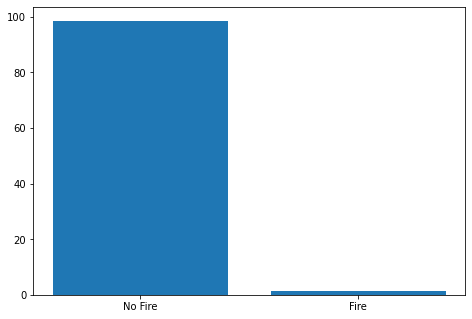

In [435]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['No Fire', 'Fire']
students = [no_fireP,fireP]
ax.bar(langs,students)
plt.show()

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Random Tree & KNN

In [16]:
rfc = RandomForestClassifier(n_estimators=100, random_state = RSEED, bootstrap=True)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [17]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
rfc_pred = rfc.predict(X_test)
rfc_prob=rfc.predict_proba(X_test)
#rfc_prob

In [14]:
rfc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [439]:
print(confusion_matrix(y_test,rfc_pred))

[[46884    66]
 [  880     7]]


In [440]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.10      0.01      0.01       887

    accuracy                           0.98     47837
   macro avg       0.54      0.50      0.50     47837
weighted avg       0.97      0.98      0.97     47837



In [441]:
print ("Depth of Tree")
[estimator.tree_.max_depth for estimator in rfc.estimators_]

Depth of Tree


[32, 37, 37, 33, 34, 31, 42, 36, 36, 38]

In [442]:
knn=KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_preds=knn.predict(X_test)
print(classification_report(y_test,knn_preds))
print(confusion_matrix(y_test,knn_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.20      0.00      0.00       887

    accuracy                           0.98     47837
   macro avg       0.59      0.50      0.50     47837
weighted avg       0.97      0.98      0.97     47837

[[46946     4]
 [  886     1]]


In [391]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

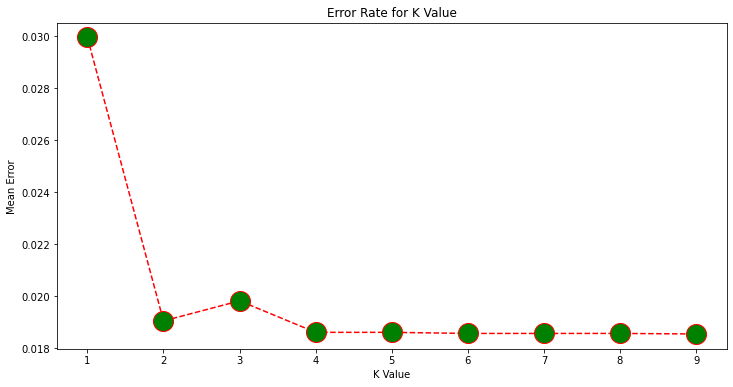

In [394]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=20)
plt.title('Error Rate for K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [368]:
X_train.columns

Index(['lat_rnd', 'lon_rnd', 'max_fpi', 'min_fpi', 'avg_fpi', 'std_fpi'], dtype='object')

In [467]:
X_train=df[['lat_rnd', 'lon_rnd','max_fpi','min_fpi', 'avg_fpi', 'std_fpi']]
y_train=df['fire_occurrence']
X_test=df_test[['lat_rnd', 'lon_rnd','max_fpi','min_fpi', 'avg_fpi', 'std_fpi']]
y_test=df_test['fire_occurrence']

# Forward Selection: Adding min, max, standard devitation of FPI

In [472]:
rfc = RandomForestClassifier(n_estimators=10, random_state = RSEED, bootstrap=True)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[46912    38]
 [  877    10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.21      0.01      0.02       887

    accuracy                           0.98     47837
   macro avg       0.59      0.51      0.51     47837
weighted avg       0.97      0.98      0.97     47837



In [449]:
knn=KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_preds=knn.predict(X_test)


In [318]:
print(classification_report(y_test,knn_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.50      0.00      0.00       887

    accuracy                           0.98     47837
   macro avg       0.74      0.50      0.50     47837
weighted avg       0.97      0.98      0.97     47837



# Feature Importance from Random Tree

In [457]:
feature_list = list(X_train.columns)
importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: std_fpi              Importance: 0.3
Variable: avg_fpi              Importance: 0.23
Variable: max_fpi              Importance: 0.14
Variable: min_fpi              Importance: 0.13
Variable: lat_rnd              Importance: 0.11
Variable: lon_rnd              Importance: 0.1


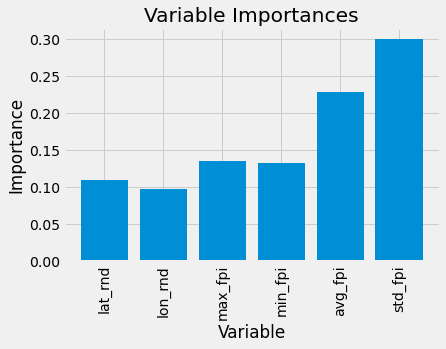

In [456]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [400]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

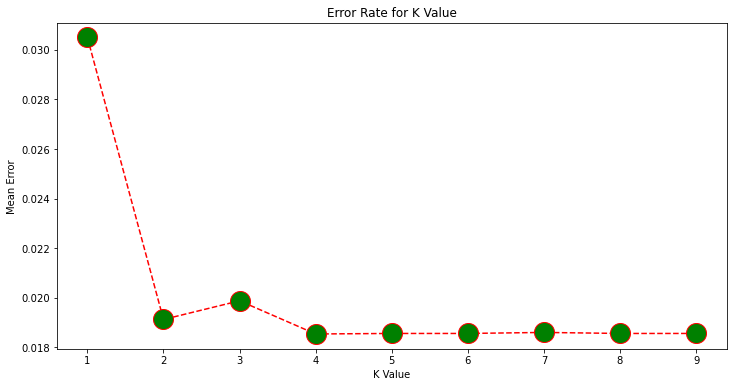

In [401]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=20)
plt.title('Error Rate for K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Adding 80 to 1 class weights

In [366]:
weights = dict({0:1, 1:80})
rfc = RandomForestClassifier(n_estimators=10, random_state = RSEED, bootstrap=True, class_weight=weights)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[46846   104]
 [  876    11]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.10      0.01      0.02       887

    accuracy                           0.98     47837
   macro avg       0.54      0.51      0.51     47837
weighted avg       0.97      0.98      0.97     47837



# Import all features

In [6]:
X_train=df[['lat_rnd', 'lon_rnd','max_fpi','min_fpi', 'avg_fpi','std_fpi','daily_ref_evapotrans_mm',
      'hundred_hour_dead_fuel_moist_percent', 'precip_amount_mm',
      'max_relative_humidity_percent', 'min_relative_humidity_percent',
      'specific_humidity_kg_kg', 'srad_wmm', 'temp_min_k', 'temp_max_k',
      'mean_vapor_pressure_deficit_kpa', 'wind_speed_10m_m_s']]
y_train=df['fire_occurrence']
X_test=df_test[['lat_rnd', 'lon_rnd','max_fpi','min_fpi', 'avg_fpi','std_fpi','daily_ref_evapotrans_mm',
      'hundred_hour_dead_fuel_moist_percent', 'precip_amount_mm',
      'max_relative_humidity_percent', 'min_relative_humidity_percent',
      'specific_humidity_kg_kg', 'srad_wmm', 'temp_min_k', 'temp_max_k',
      'mean_vapor_pressure_deficit_kpa', 'wind_speed_10m_m_s']]
y_test=df_test['fire_occurrence']

In [463]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X_train2 = add_constant(X_train)
#X_train2 = X_train2.drop('mean_vapor_pressure_deficit_kpa', 1)
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train2.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train2.values, i) 
                          for i in range(len(X_train2.columns))] 
  
print(vif_data)

                                 feature            VIF
0                                  const  208242.883424
1                                lat_rnd       2.183007
2                                lon_rnd       2.184275
3                                max_fpi      39.706792
4                                min_fpi      45.069437
5                                avg_fpi      49.547560
6                                std_fpi      14.285789
7                daily_ref_evapotrans_mm      11.433608
8   hundred_hour_dead_fuel_moist_percent       6.432350
9                       precip_amount_mm       1.049431
10         max_relative_humidity_percent      14.530584
11         min_relative_humidity_percent      13.359910
12               specific_humidity_kg_kg      15.281306
13                              srad_wmm       1.731942
14                            temp_min_k      13.090937
15                            temp_max_k      41.041347
16       mean_vapor_pressure_deficit_kpa      42

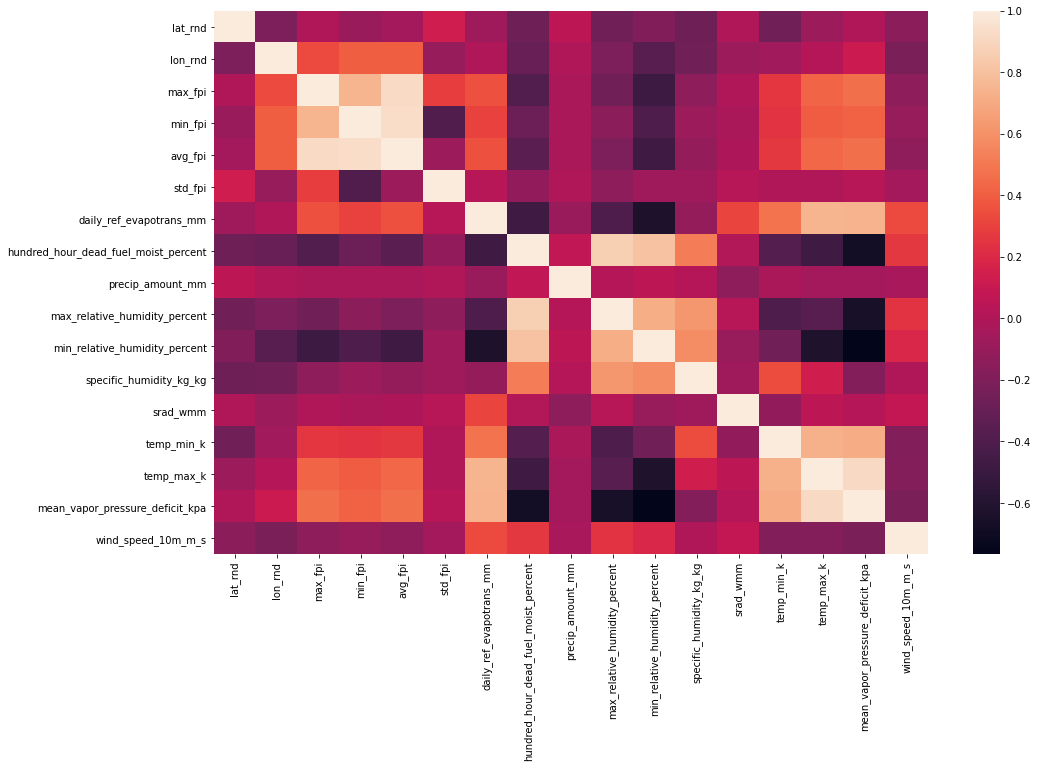

In [404]:
import seaborn as sns
cor = X_train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)
plt.show()

In [14]:
rfc = RandomForestClassifier(n_estimators=10, random_state = RSEED, bootstrap=True)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[46942     8]
 [  884     3]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.27      0.00      0.01       887

    accuracy                           0.98     47837
   macro avg       0.63      0.50      0.50     47837
weighted avg       0.97      0.98      0.97     47837



# Feature Importance from Random Tree

In [15]:
feature_list = list(X_train.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hundred_hour_dead_fuel_moist_percent Importance: 0.08
Variable: srad_wmm             Importance: 0.08
Variable: std_fpi              Importance: 0.07
Variable: daily_ref_evapotrans_mm Importance: 0.07
Variable: min_relative_humidity_percent Importance: 0.07
Variable: specific_humidity_kg_kg Importance: 0.07
Variable: temp_min_k           Importance: 0.07
Variable: temp_max_k           Importance: 0.07
Variable: mean_vapor_pressure_deficit_kpa Importance: 0.07
Variable: wind_speed_10m_m_s   Importance: 0.07
Variable: max_relative_humidity_percent Importance: 0.06
Variable: min_fpi              Importance: 0.05
Variable: avg_fpi              Importance: 0.05
Variable: lat_rnd              Importance: 0.04
Variable: lon_rnd              Importance: 0.04
Variable: max_fpi              Importance: 0.04
Variable: precip_amount_mm     Importance: 0.0


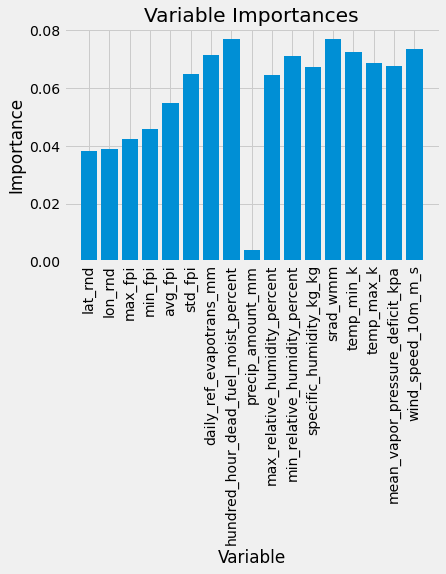

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [451]:
knn=KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_preds=knn.predict(X_test)
print(classification_report(y_test,knn_preds))
print(confusion_matrix(y_test,knn_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     46950
           1       0.00      0.00      0.00       887

    accuracy                           0.98     47837
   macro avg       0.49      0.50      0.50     47837
weighted avg       0.96      0.98      0.97     47837

[[46946     4]
 [  887     0]]


# Working Code

# Ensemble Cross Validation

In [452]:
"Citation: https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16"

'Citation: https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16'

In [26]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
            
        return train_pred, test_pred, recall_scores, f1_scores

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)

rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20], 
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf' : [4, 8, 12],
              'n_estimators' : [300, 400, 500]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 